<a href="https://colab.research.google.com/github/ferozferoz/DeepLearn/blob/master/object_detection_using_yolo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
pip install scipy==1.1.0

In [0]:
import numpy as np
from keras.models import load_model, Model
from matplotlib.pyplot import imshow
import tensorflow as tf
from keras import backend as K
from keras.layers import Input, Lambda, Conv2D
from keras.layers import Lambda
from keras.layers.merge import concatenate
import colorsys
import PIL
import imghdr
import scipy.io
import scipy.misc
import os
import random
from PIL import Image, ImageDraw, ImageFont
sess = K.get_session()

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
def read_classes(classes_path):
  with open(classes_path) as f:
    class_names = f.readlines()
    class_names = [c.strip() for c in class_names]
    class_names = np.array(class_names)
  return class_names

def read_anchors(anchors_path):
  with open(anchors_path) as f:
    anchors = f.readline()
    anchors = [float(x) for x in anchors.split(',')]
    anchors = np.array(anchors).reshape(-1, 2)
    return anchors

In [4]:
root_dir = '/content/gdrive/My Drive/ColabNotebooks/AutoCar'
class_names = read_classes(root_dir+"/classes.txt")
anchors = read_anchors(root_dir+"/yolo_anchors.txt")
image_shape = (720., 1280.)
yolo_model = load_model(root_dir+"/yolo.h5")

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [5]:
yolo_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 608, 608, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 608, 608, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 608, 608, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 608, 608, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [0]:
def yolo_head(feats, anchors, num_classes):
    """Convert final layer features to bounding box parameters.
    Parameters
    ----------
    feats : tensor
        Final convolutional layer features.
    anchors : array-like
        Anchor box widths and heights.
    num_classes : int
        Number of target classes.
    Returns
    -------
    box_xy : tensor
        x, y box predictions adjusted by spatial location in conv layer.
    box_wh : tensor
        w, h box predictions adjusted by anchors and conv spatial resolution.
    box_conf : tensor
        Probability estimate for whether each box contains any object.
    box_class_pred : tensor
        Probability distribution estimate for each box over class labels.
    """
    num_anchors = len(anchors)
    # Reshape to batch, height, width, num_anchors, box_params.
    anchors_tensor = K.reshape(K.variable(anchors), [1, 1, 1, num_anchors, 2])
    # Static implementation for fixed models.
    # TODO: Remove or add option for static implementation.
    # _, conv_height, conv_width, _ = K.int_shape(feats)
    # conv_dims = K.variable([conv_width, conv_height])

    # Dynamic implementation of conv dims for fully convolutional model.
    conv_dims = K.shape(feats)[1:3]  # assuming channels last
    # In YOLO the height index is the inner most iteration.
    conv_height_index = K.arange(0, stop=conv_dims[0])
    conv_width_index = K.arange(0, stop=conv_dims[1])
    conv_height_index = K.tile(conv_height_index, [conv_dims[1]])
    # TODO: Repeat_elements and tf.split doesn't support dynamic splits.
    # conv_width_index = K.repeat_elements(conv_width_index, conv_dims[1], axis=0)
    conv_width_index = K.tile(K.expand_dims(conv_width_index, 0), [conv_dims[0], 1])
    conv_width_index = K.flatten(K.transpose(conv_width_index))
    conv_index = K.transpose(K.stack([conv_height_index, conv_width_index]))
    conv_index = K.reshape(conv_index, [1, conv_dims[0], conv_dims[1], 1, 2])
    conv_index = K.cast(conv_index, 'float32')
    feats = K.reshape(feats, [-1, conv_dims[0], conv_dims[1], num_anchors, num_classes + 5])
    conv_dims = K.cast(K.reshape(conv_dims, [1, 1, 1, 1, 2]), 'float32')

    box_confidence = K.sigmoid(feats[..., 4:5])
    box_xy = K.sigmoid(feats[..., :2])
    box_wh = K.exp(feats[..., 2:4])
    box_class_probs = K.softmax(feats[..., 5:])
    box_xy = (box_xy + conv_index) / conv_dims
    box_wh = box_wh * anchors_tensor / conv_dims
    return box_confidence, box_xy, box_wh, box_class_probs;

In [0]:
def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
  max_boxes_tensor = K.variable(max_boxes, dtype='int32')     # tensor to be used in tf.image.non_max_suppression()
  K.get_session().run(tf.variables_initializer([max_boxes_tensor])) # initialize variable max_boxes_tensor
  nms_indices = tf.image.non_max_suppression(boxes, scores, max_boxes_tensor, iou_threshold=iou_threshold)
  scores = K.gather(scores, nms_indices)
  boxes = K.gather(boxes, nms_indices)
  classes = K.gather(classes, nms_indices)
  return scores, boxes, classes

In [0]:
def preprocess_image(img_path, model_image_size):
    image_type = imghdr.what(img_path)
    image = Image.open(img_path)
    resized_image = image.resize(tuple(reversed(model_image_size)), Image.BICUBIC)
    image_data = np.array(resized_image, dtype='float32')
    image_data /= 255.
    image_data = np.expand_dims(image_data, 0)  # Add batch dimension.
    return image, image_data

def generate_colors(class_names):
    hsv_tuples = [(x / len(class_names), 1., 1.) for x in range(len(class_names))]
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), colors))
    random.seed(10101)  # Fixed seed for consistent colors across runs.
    random.shuffle(colors)  # Shuffle colors to decorrelate adjacent classes.
    random.seed(None)  # Reset seed to default.
    return colors

def scale_boxes(boxes, image_shape):
    """ Scales the predicted boxes in order to be drawable on the image"""
    height = image_shape[0]
    width = image_shape[1]
    image_dims = K.stack([height, width, height, width])
    image_dims = K.reshape(image_dims, [1, 4])
    boxes = boxes * image_dims
    return boxes
    
def draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors):
  font = ImageFont.truetype(font='/content/gdrive/My Drive/ColabNotebooks/AutoCar/FiraMono-Medium.otf',size=np.floor(3e-2 * image.size[1] + 0.5).astype('int32'))
  thickness = (image.size[0] + image.size[1]) // 300
  for i, c in reversed(list(enumerate(out_classes))):
    predicted_class = class_names[c]
    box = out_boxes[i]
    score = out_scores[i]
    label = '{} {}'.format(predicted_class,score)
    draw = ImageDraw.Draw(image)
    label_size = draw.textsize(label, font)
    print(box)
    top, left, bottom, right = box
    top = max(0, np.floor(top + 0.5).astype('int32'))
    left = max(0, np.floor(left + 0.5).astype('int32'))
    bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
    right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
    print(label, (left, top), (right, bottom))
    if top - label_size[1] >= 0:
      text_origin = np.array([left, top - label_size[1]])
    else:
      text_origin = np.array([left, top + 1])
    # My kingdom for a good redistributable image drawing library.
    for i in range(thickness):
      draw.rectangle([left + i, top + i, right - i, bottom - i], outline=colors[c])
      draw.rectangle([tuple(text_origin), tuple(text_origin + label_size)], fill=colors[c])
      draw.text(text_origin, label, fill=(0, 0, 0), font=font)
    del draw

In [0]:
def yolo_eval(yolo_outputs,
              image_shape= (720., 1280.),
              max_boxes=10,
              score_threshold=.6,
              iou_threshold=.5):
    """Evaluate YOLO model on given input batch and return filtered boxes."""
    box_confidence, box_xy, box_wh, box_class_probs = yolo_outputs
    boxes = yolo_boxes_to_corners(box_xy, box_wh)
    boxes, scores, classes = yolo_filter_boxes(
        box_confidence, boxes, box_class_probs, threshold=score_threshold)
    boxes = scale_boxes(boxes, image_shape)
    scores, boxes1, classes = yolo_non_max_suppression(scores, boxes, classes, max_boxes = max_boxes, iou_threshold = iou_threshold)
    return boxes1, scores, classes

def yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold=.4):
    """Filter YOLO boxes based on object and class confidence."""

    box_scores = box_confidence * box_class_probs
    box_classes = K.argmax(box_scores, axis=-1)
    box_class_scores = K.max(box_scores, axis=-1)
    filtering_mask = K.greater_equal(box_class_scores, threshold)
    
    # TODO: Expose tf.boolean_mask to Keras backend?
    boxes = tf.boolean_mask(boxes, filtering_mask)
    scores = tf.boolean_mask(box_class_scores, filtering_mask)
    classes = tf.boolean_mask(box_classes, filtering_mask)

    return boxes, scores, classes
def yolo_boxes_to_corners(box_xy, box_wh):
    """Convert YOLO box predictions to bounding box corners."""
    box_mins = box_xy - (box_wh / 2.)
    box_maxes = box_xy + (box_wh / 2.)

    return K.concatenate([
        box_mins[..., 1:2],  # y_min
        box_mins[..., 0:1],  # x_min
        box_maxes[..., 1:2],  # y_max
        box_maxes[..., 0:1]  # x_max
    ])


In [145]:
yolo_model.output

<tf.Tensor 'conv2d_23_1/BiasAdd:0' shape=(?, 19, 19, 425) dtype=float32>

In [0]:
yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))

In [126]:
with tf.Session() as test_b:
    yolo_outputs = (tf.random_normal([19, 19, 5, 1], mean=1, stddev=4, seed = 1),
                    tf.random_normal([19, 19, 5, 2], mean=1, stddev=4, seed = 1),
                    tf.random_normal([19, 19, 5, 2], mean=1, stddev=4, seed = 1),
                    tf.random_normal([19, 19, 5, 80], mean=1, stddev=4, seed = 1))
    boxes, scores, classes = yolo_eval(yolo_outputs)
    print("scores[2] = " + str(scores[2].eval()))
    print("boxes[2] = " + str(boxes.eval().shape))
    print("classes[2] = " + str(classes[2].eval()))
    print("scores.shape = " + str(scores.eval().shape))
    print("boxes.shape = " + str(boxes.eval().shape))
    print("classes.shape = " + str(classes.eval().shape))

boxes.shape = (1784, 4)
boxes.shape = (1774, 4)
nms_indices = [ 819 1473 1749 1711  262 1122  817  818 1458  761]
boxes1.shape = (10, 4)
scores[2] = 142.56306
boxes[2] = (10, 4)
classes[2] = 56
scores.shape = (10,)
boxes.shape = (10, 4)
classes.shape = (10,)


In [12]:
boxes, scores, classes = yolo_eval(yolo_outputs)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
def predict(sess, image_file):
    """
    Runs the graph stored in "sess" to predict boxes for "image_file". Prints and plots the preditions.
    
    Arguments:
    sess -- your tensorflow/Keras session containing the YOLO graph
    image_file -- name of an image stored in the "images" folder.
    
    Returns:
    out_scores -- tensor of shape (None, ), scores of the predicted boxes
    out_boxes -- tensor of shape (None, 4), coordinates of the predicted boxes
    out_classes -- tensor of shape (None, ), class index of the predicted boxes
    
    Note: "None" actually represents the number of predicted boxes, it varies between 0 and max_boxes. 
    """

    # Preprocess your image
    image, image_data = preprocess_image(root_dir+"/images/" + image_file, model_image_size = (608, 608))
    # Run the session with the correct tensors and choose the correct placeholders in the feed_dict.
    # You'll need to use feed_dict={yolo_model.input: ... , K.learning_phase(): 0})
    ### START CODE HERE ### (≈ 1 line)
    print(image_data.shape)
    out_boxes,out_scores,  out_classes = sess.run([boxes,scores, classes], feed_dict={yolo_model.input: image_data, K.learning_phase(): 0})
    ### END CODE HERE ###
    print(out_boxes.shape)
    # Print predictions info
    print('Found {} boxes for {}'.format(len(out_boxes), image_file))
    # Generate colors for drawing bounding boxes.
    colors = generate_colors(class_names)
    # Draw bounding boxes on the image file
    draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors)
    # Save the predicted bounding box on the image
    image.save(os.path.join("/content/gdrive/My Drive/ColabNotebooks/AutoCar/out", image_file), quality=90)
    # Display the results in the notebook
    
    output_image = scipy.misc.imread(os.path.join("/content/gdrive/My Drive/ColabNotebooks/AutoCar/out", image_file))
    imshow(output_image)
    
    return out_scores, out_boxes, out_classes

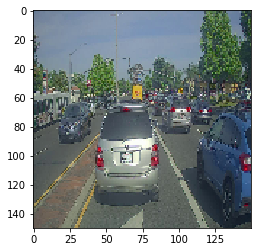

In [17]:
import matplotlib.pyplot as plt
from keras.preprocessing.image import image
img = image.load_img("/content/gdrive/My Drive/ColabNotebooks/AutoCar/images/test.jpg",target_size=(150,150))
plt.imshow(img)


(1, 608, 608, 3)
(7, 4)
Found 7 boxes for test.jpg
[ 285.30835  924.8932   373.71942 1044.8964 ]
car 0.6022345423698425 (925, 285) (1045, 374)
[279.12592 705.8778  350.35123 785.50183]
car 0.6648430824279785 (706, 279) (786, 350)
[266.24033    4.542246 407.19052  220.25299 ]
bus 0.6702377796173096 (5, 266) (220, 407)
[ 323.58554  947.2076   704.68567 1287.6368 ]
car 0.6959935426712036 (947, 324) (1280, 705)
[302.6241  158.60413 439.83768 346.32666]
car 0.7437030673027039 (159, 303) (346, 440)
[282.00867 761.47485 411.6477  942.45355]
car 0.7959001064300537 (761, 282) (942, 412)
[299.76297 366.54007 647.9238  745.10864]
car 0.8912788033485413 (367, 300) (745, 648)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


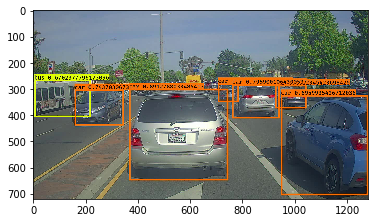

In [14]:
out_scores, out_boxes, out_classes = predict(sess, "test.jpg")